<h1><center><a> Loan Eligibility Prediction </a></center></h1>

<h2><center><a>Problem Statement</a></center></h2>
Company wants to `automate` the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

In [2]:
#Load Libraries
import pandas as pd # data processing
import numpy as np # linear algebra
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import os # directory
from PIL import Image
%matplotlib inline
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter
from IPython.core.display import HTML

Using TensorFlow backend.


<h1><center><a> Data Overview </a></center></h1>

In [3]:
# Load train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
# data overview
def missing_zero_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Missing Values'})
        mz_table['Data Type'] = df.dtypes
        mz_table['Unique Values'] = df.nunique()
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Missing Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

missing_zero_values_table(train)

Your selected dataframe has 13 columns and 614 Rows.
There are 7 columns that have missing values.


,Missing Values,% of Total Missing Values,Data Type,Unique Values
Credit_History,50,8.1,float64,2
Self_Employed,32,5.2,object,2
LoanAmount,22,3.6,float64,203
Dependents,15,2.4,object,4
Loan_Amount_Term,14,2.3,float64,10
Gender,13,2.1,object,2
Married,3,0.5,object,2


<h1><center><a> EDA </a></center></h1>

<a> **Uni-variate Analysis** </a>

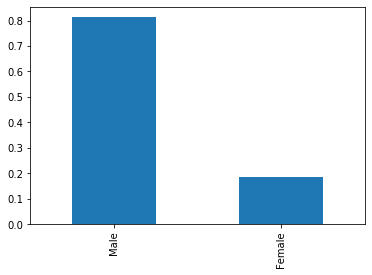

In [6]:
#1. Gender
train['Gender'].value_counts(normalize=True).plot.bar()

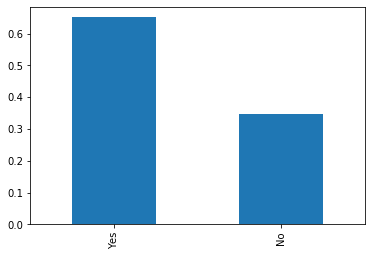

In [7]:
#2. Marital Status
train['Married'].value_counts(normalize=True).plot.bar()

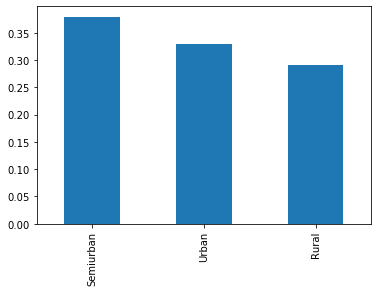

In [8]:
#3. Property_Area
train['Property_Area'].value_counts(normalize=True).plot.bar()

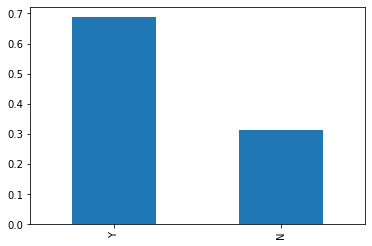

In [9]:
#4. Loan Status
train['Loan_Status'].value_counts(normalize=True).plot.bar()

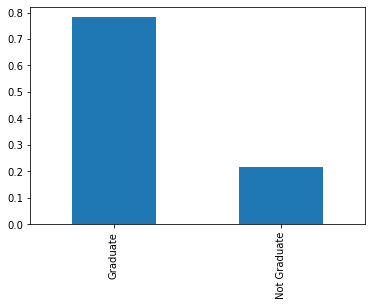

In [10]:
#4. Education
train['Education'].value_counts(normalize=True).plot.bar()

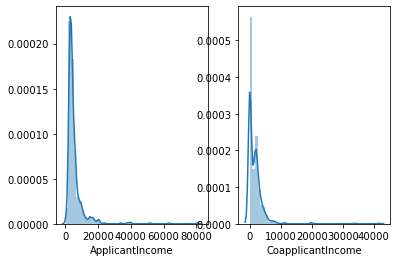

In [11]:
# Numerical Variable
#1.ApplicantIncome and CoApplicantIncome
plt.subplot(121)
sns.distplot(train['ApplicantIncome'])
plt.subplot(122)
sns.distplot(train['CoapplicantIncome'])

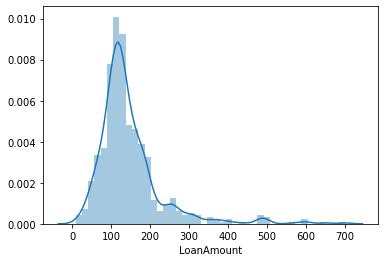

In [12]:
# Distribution of LoanAmount
df1 = train
sns.distplot(df1['LoanAmount'].dropna())

<a> **Uni-variate analysis Insights**</a>

* Majority of the applicants are **graduates** (~**80%**)
* Both **Applicant-Income** and **Loan Amount** approximately follow normal distribution with a lot of **OUTLIERS** on the right
* Given, most of the applicants are **graduates** that has also resulted in **70%** of loans being sanctioned - this fact will be tested in **Bivariate Analysis**
* Majority of people are **married** and are **male**
* Loan status is **unbalnced** because majority class is **Yes**

<a> **Bi-variate Analysis** </a>

<a> **1. Categorical/Discrete Data** </a>

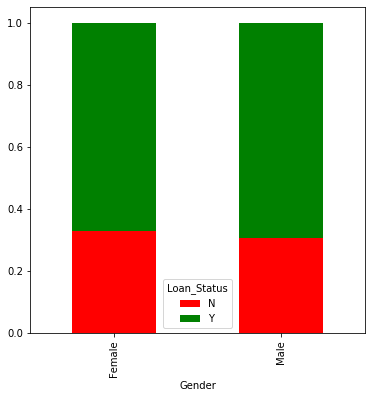

In [13]:
# (a) Gender vs Loan_Status
Gender=pd.crosstab(train['Gender'],train['Loan_Status']) 
Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,6),color = ['r','g'])

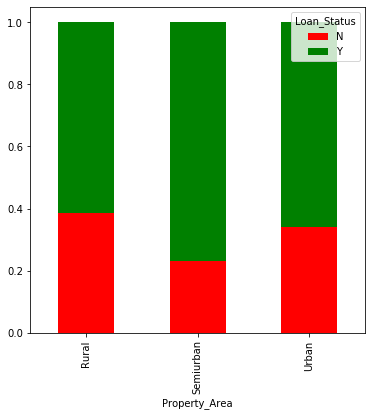

In [14]:
#(b).Area Type vs Loan_Status
Area = pd.crosstab(train['Property_Area'],train['Loan_Status'])
Area.div(Area.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(6,6),color = ['r','g'])

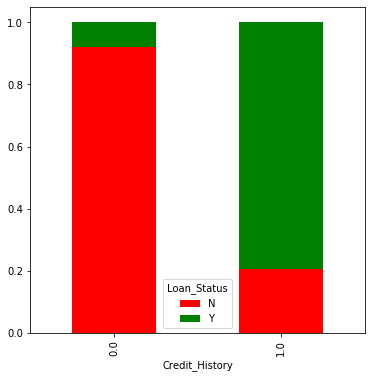

In [15]:
#(c).Credit History vs Loan_Status
Credit = pd.crosstab(train['Credit_History'],train['Loan_Status'])
Credit.div(Credit.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize= (6,6),color=['r','g'])

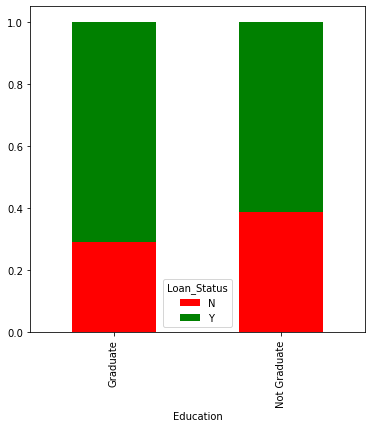

In [16]:
#(d) Education Vs Loan_Status
Edu = pd.crosstab(train['Education'],train['Loan_Status'])
Edu.div(Edu.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(6,6),color= ['r','g'])

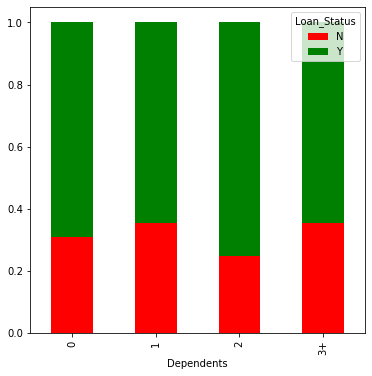

In [17]:
#(e) Dependents Vs Loan_Status
dep = pd.crosstab(train['Dependents'],train['Loan_Status'])
dep.div(dep.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(6,6),color=['r','g'])

<a> **Bi-Variate Insights Categorical/Discrete Data** </a>

* Although % of **Male** getting their loan amount sanctioned is **marginally higher** than their **female** counterparts, considering the number of males in the dataset from univariate analysis, we can say **Gender has very little to do with Loan Staus atleast in this dataset**.

* **Semi-urban** area type seems to have **higher loan sanction percentage** when compared to **rural and urban areas**

* This is a no **brainer**, people with a good **credit history** have a better **loan sanction percentage**.

* **Graduates** fare mariginally better when compared to **not graduate**

* **no of dependents = 2** has the highest **loan sanction percentage** while **1,3** are the least sanctioned


<a> **2.Numerical-Data** </a>

Text(0, 0.5, 'Percentage')

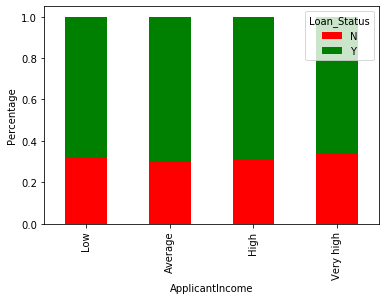

In [18]:
#(a).Applicant Income Vs Loan_Status
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high']
df1['Income_bin']=pd.cut(df1['ApplicantIncome'],bins,labels=group)
Income_bin=pd.crosstab(df1['Income_bin'],df1['Loan_Status']) 
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,color = ['r','g']) 
plt.xlabel('ApplicantIncome') 
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

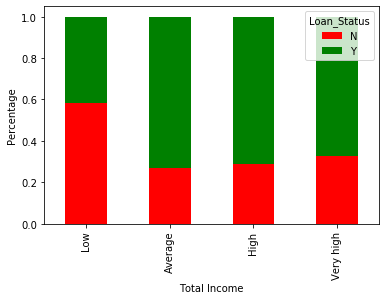

In [19]:
#(b) Lets a create a new variable TotalIncome = ApplicantIncome+CoApplicantIncome
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
df1 = train.copy()
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high'] 
df1['Total_Income_bin']=pd.cut(df1['Total_Income'],bins,labels=group)
Total_Income_bin=pd.crosstab(df1['Total_Income_bin'],df1['Loan_Status']) 
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,color = ['r','g']) 
plt.xlabel('Total Income') 
plt.ylabel('Percentage')

In [20]:
# Now lets replace 3+ in Dependents and 'Yes' and 'No' in Loan_Status
df_train = train
df_train['Dependents'].replace('3+', 3,inplace=True) 
df_train['Loan_Status'].replace('N', 0,inplace=True) 
df_train['Loan_Status'].replace('Y', 1,inplace=True)
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']
df_test = test
df_test['Dependents'].replace('3+', 3,inplace=True)
# Lets drop 'ApplicantIncome' and 'CoapplicantIncome' from train and test data
df_train.drop('ApplicantIncome',axis=1,inplace=True)
df_train.drop('CoapplicantIncome',axis=1,inplace=True)
df_test.drop('ApplicantIncome',axis=1,inplace=True)
df_test.drop('CoapplicantIncome',axis=1,inplace=True)

<a> **Correlation-Matrix** </a>

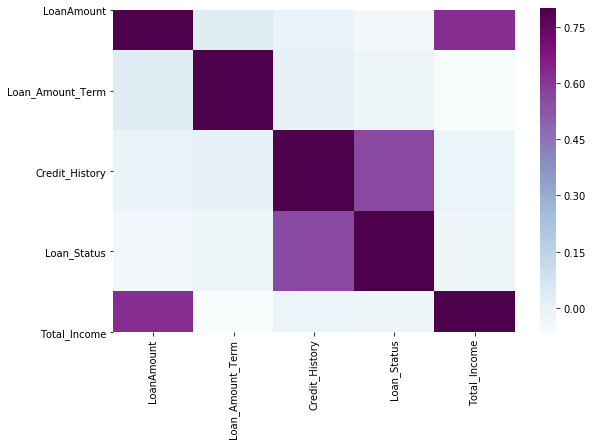

In [21]:
matrix = df_train.corr() 
f, ax = plt.subplots(figsize=(9, 6)) 
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu")

<a> **Bi-Variate-Numerical data and Correlation Insights** </a>

* **Credit History** and **Loan Status** are **correlated**
* So is **Loan Amount** and **Total Income** from the matrix
* There is little bit **disparity** in terms of **Total Income** and **Loan Status** i.e **low income group** have less chances of getting **loan**.

<h1><center><a> Data Pre-Prerocessing </a></center></h1>

<a> **Missing Value Imputaion in train data** </a>

In [22]:
# Impute categorical variables by mode method
df_train['Gender'].fillna(df_train['Gender'].mode()[0], inplace=True) 
df_train['Married'].fillna(df_train['Married'].mode()[0], inplace=True) 
df_train['Dependents'].fillna(df_train['Dependents'].mode()[0], inplace=True) 
df_train['Self_Employed'].fillna(df_train['Self_Employed'].mode()[0], inplace=True) 
df_train['Credit_History'].fillna(df_train['Credit_History'].mode()[0], inplace=True)
df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mode()[0],inplace=True)

<a> Impute missing value in **Loan_amount** , but insted of filling the **loan amount** with simple **mean** or **median** lets check its relation with gender,married and other variables using pivot table.

In [23]:
# Pivot Table
data = df_train.pivot_table(values='LoanAmount',index=['Gender','Married','Self_Employed'],aggfunc=np.mean)
data

LoanAmount
Gender Married Self_Employed            
Female No      No             114.691176
               Yes            125.800000
       Yes     No             134.222222
               Yes            282.250000
Male   No      No             129.936937
               Yes            180.588235
       Yes     No             153.882736
               Yes            169.395833

<a> So from the pivot table it is clear that **Loan Amount** is related to **Gender**,**Married**and**Self_Employed** so we will impute missing value in **Loan Amount** from the **Mean** of these **features** from the **Pivot Table** </a>

In [24]:
#iterate only through rows with missing LoanAmount
for i,row in df_train.loc[df_train['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  df_train.loc[i,'LoanAmount'] = data.loc[ind].values[0]

In [25]:
# Now check missing value in df_train dataset
df_train.isnull().sum()

Loan_ID             0
Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Loan_Status         0
Income_bin          0
Total_Income        0
dtype: int64

<a> **Missing Value Imputaion in test data** </a>

In [26]:
# Impute categorical variables by mode method
df_test['Gender'].fillna(df_test['Gender'].mode()[0], inplace=True) 
df_test['Married'].fillna(df_test['Married'].mode()[0], inplace=True) 
df_test['Dependents'].fillna(df_test['Dependents'].mode()[0], inplace=True) 
df_test['Self_Employed'].fillna(df_test['Self_Employed'].mode()[0], inplace=True) 
df_test['Credit_History'].fillna(df_test['Credit_History'].mode()[0], inplace=True)
df_test['Loan_Amount_Term'].fillna(df_test['Loan_Amount_Term'].mode()[0],inplace=True)

In [27]:
#iterate only through rows with missing LoanAmount
for i,row in df_test.loc[df_test['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  df_test.loc[i,'LoanAmount'] = data.loc[ind].values[0]

In [28]:
df_test.isnull().sum()

Loan_ID             0
Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Total_Income        0
dtype: int64

<h1><center><a> Outlier Treatment </a></center></h1>

<a> **Rectifying Skewness** </a>

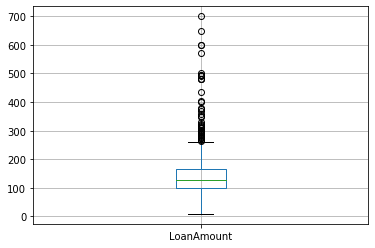

In [29]:
#1.Loan Amount
df_train.boxplot(column='LoanAmount')

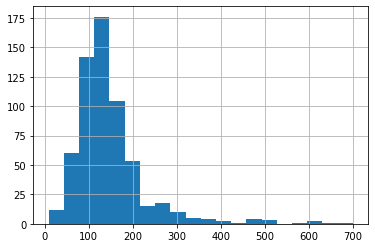

In [30]:
train.LoanAmount.hist(bins=20)

<a> So from the above two graphs we can conclude that **Loan Amount** is **right skewed** 

<a> Apply **Log Transformation** To remove **skewness**

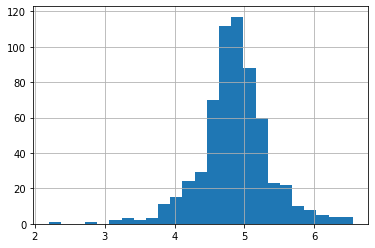

In [31]:
df_train['LoanAmount_log'] = np.log(df_train['LoanAmount'])
df_test['LoanAmount_log'] = np.log(df_test['LoanAmount'])
df_train['LoanAmount_log'].hist(bins=25)

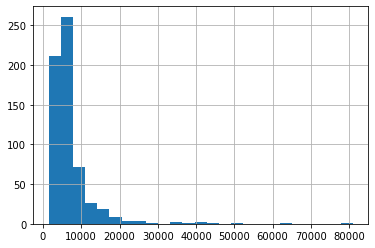

In [32]:
# Now check Total_Income
df_train['Total_Income'].hist(bins=25)

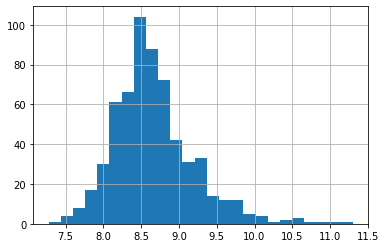

In [33]:
df_train['Total_Income_log'] = np.log(df_train['Total_Income'])
df_test['Total_Income_log'] = np.log(df_test['Total_Income'])
df_train['Total_Income_log'].hist(bins=25)

<h1><center><a> Model Building </a></center></h1>

<a> **Feature Engineering** </a>

In [34]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Loan_Status', 'Income_bin', 'Total_Income',
       'LoanAmount_log', 'Total_Income_log'],
      dtype='object')

In [35]:
df_test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Total_Income', 'LoanAmount_log', 'Total_Income_log'],
      dtype='object')

In [36]:
df_train = df_train.drop(['Income_bin', 'Total_Income'], axis=1) # we removed Total_Income because we have taken its log
df_train=df_train.drop('Loan_ID',axis=1) # It has no significanse
df_test=df_test.drop('Loan_ID',axis=1)
df_train = df_train.drop('LoanAmount',axis=1) # we have taken its log
df_test = df_test.drop('LoanAmount',axis=1)
df_test = df_test.drop('Total_Income',axis=1)
X = df_train.drop('Loan_Status',1) 
y = df_train['Loan_Status'].astype('category')
X=pd.get_dummies(X) 
df_train=pd.get_dummies(df_train) 
df_test=pd.get_dummies(df_test)

In [37]:
# Lets check the data types of our dataset
df_train.dtypes

Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int64
LoanAmount_log             float64
Total_Income_log           float64
Gender_Female                uint8
Gender_Male                  uint8
Married_No                   uint8
Married_Yes                  uint8
Dependents_3                 uint8
Dependents_0                 uint8
Dependents_1                 uint8
Dependents_2                 uint8
Education_Graduate           uint8
Education_Not Graduate       uint8
Self_Employed_No             uint8
Self_Employed_Yes            uint8
Property_Area_Rural          uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
dtype: object

In [38]:
df_test.dtypes

Loan_Amount_Term           float64
Credit_History             float64
LoanAmount_log             float64
Total_Income_log           float64
Gender_Female                uint8
Gender_Male                  uint8
Married_No                   uint8
Married_Yes                  uint8
Dependents_3                 uint8
Dependents_0                 uint8
Dependents_1                 uint8
Dependents_2                 uint8
Education_Graduate           uint8
Education_Not Graduate       uint8
Self_Employed_No             uint8
Self_Employed_Yes            uint8
Property_Area_Rural          uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
dtype: object

In [39]:
X.dtypes

Loan_Amount_Term           float64
Credit_History             float64
LoanAmount_log             float64
Total_Income_log           float64
Gender_Female                uint8
Gender_Male                  uint8
Married_No                   uint8
Married_Yes                  uint8
Dependents_3                 uint8
Dependents_0                 uint8
Dependents_1                 uint8
Dependents_2                 uint8
Education_Graduate           uint8
Education_Not Graduate       uint8
Self_Employed_No             uint8
Self_Employed_Yes            uint8
Property_Area_Rural          uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
dtype: object

In [40]:
df_train.head()

,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount_log,Total_Income_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,360.0,1.0,1,4.867049,8.674026,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1
1,360.0,1.0,0,4.852030,8.714568,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0
2,360.0,1.0,1,4.189655,8.006368,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
3,360.0,1.0,1,4.787492,8.505323,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1
4,360.0,1.0,1,4.948760,8.699515,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1


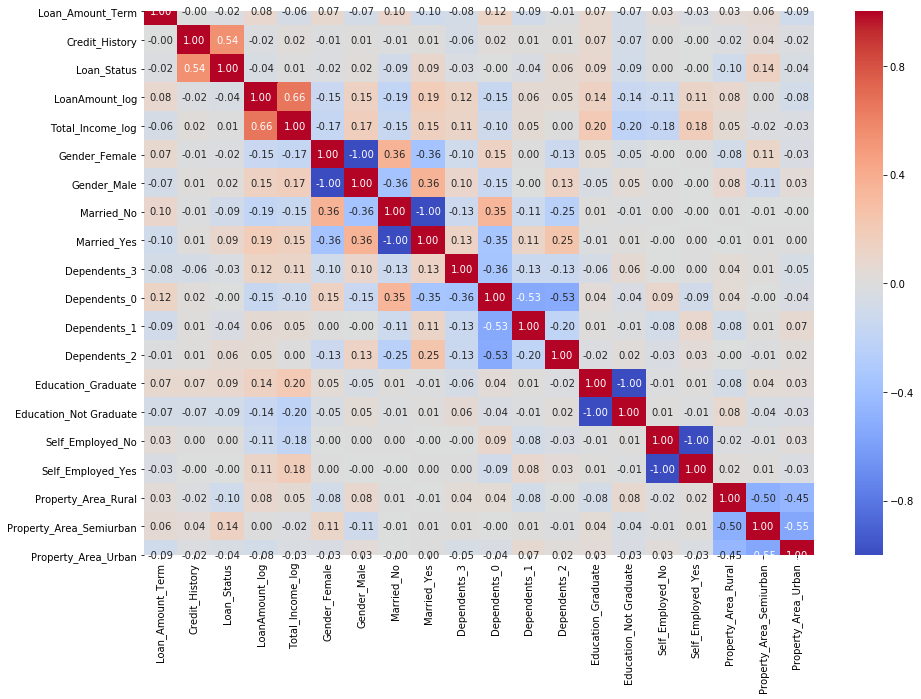

In [41]:
# Check Correlation
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
cm_df = sns.heatmap(df_train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

In [42]:
# Drop Highly Correlated features
df_train = df_train.drop('Loan_Amount_Term',1)
df_test = df_test.drop('Loan_Amount_Term',1)

<h2><center><a> 1.Logistic Regression using Stratified K-Fold </a></center></h2>

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [44]:
X.head()

,Loan_Amount_Term,Credit_History,LoanAmount_log,Total_Income_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,360.0,1.0,4.867049,8.674026,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1
1,360.0,1.0,4.852030,8.714568,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0
2,360.0,1.0,4.189655,8.006368,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
3,360.0,1.0,4.787492,8.505323,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1
4,360.0,1.0,4.948760,8.699515,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1


In [45]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: category
Categories (2, int64): [0, 1]

In [46]:
type(y)

pandas.core.series.Series

In [47]:
# Lets split the data using K-Fold
X = df_train.drop('Loan_Status',1)
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train,X_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    model1 = LogisticRegression(random_state=1,solver='lbfgs',max_iter=15000)          
    model1.fit(X_train,y_train)
    pred1 = model1.predict(X_test)
    score = accuracy_score(y_test,pred1)
    precision = metrics.precision_score(y_test,pred1)
    recall = metrics.recall_score(y_test,pred1)
    F1_score = metrics.f1_score(y_test,pred1)
    print('accuracy_score',score)
    print('Precision',precision)
    print('Recall',recall)
    print('F1_score',F1_score)
    i+=1

pred = model1.predict(df_test)


1 of kfold 5
accuracy_score 0.8064516129032258
Precision 0.7850467289719626
Recall 0.9882352941176471
F1_score 0.875

2 of kfold 5
accuracy_score 0.8064516129032258
Precision 0.801980198019802
Recall 0.9529411764705882
F1_score 0.8709677419354839

3 of kfold 5
accuracy_score 0.8032786885245902
Precision 0.7830188679245284
Recall 0.9880952380952381
F1_score 0.8736842105263158

4 of kfold 5
accuracy_score 0.7950819672131147
Precision 0.7757009345794392
Recall 0.9880952380952381
F1_score 0.8691099476439791

5 of kfold 5
accuracy_score 0.8360655737704918
Precision 0.8076923076923077
Recall 1.0
F1_score 0.8936170212765957


<a> **Plotting The ROC-Curve** </a>

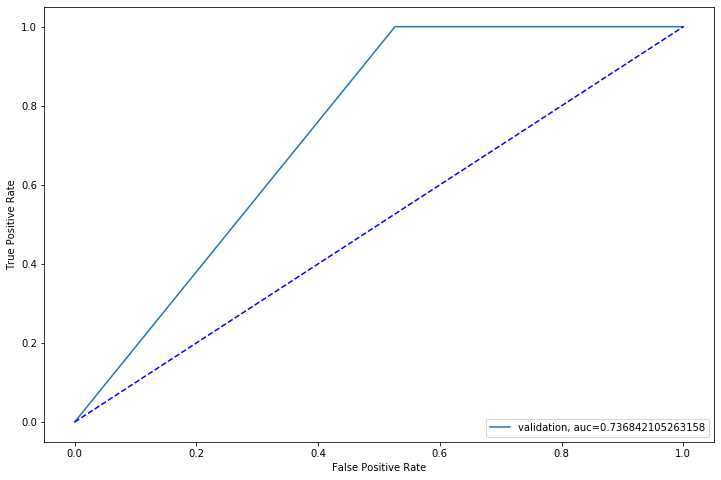

In [48]:
from sklearn import metrics
fpr,tpr,_ = metrics.roc_curve(y_test,pred1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="validation, auc="+str(auc)) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4)
plt.plot([0,1],[0,1],'b--')
plt.show()

<a> **AUC = 0.7368** </a>

<h1><center><a> Plot_Metric Library for combined AUC_ROC and Recall-Precision curve </a></center></h1>

In [49]:
# Another Library for ROC_auc curve
from plot_metric.functions import BinaryClassification

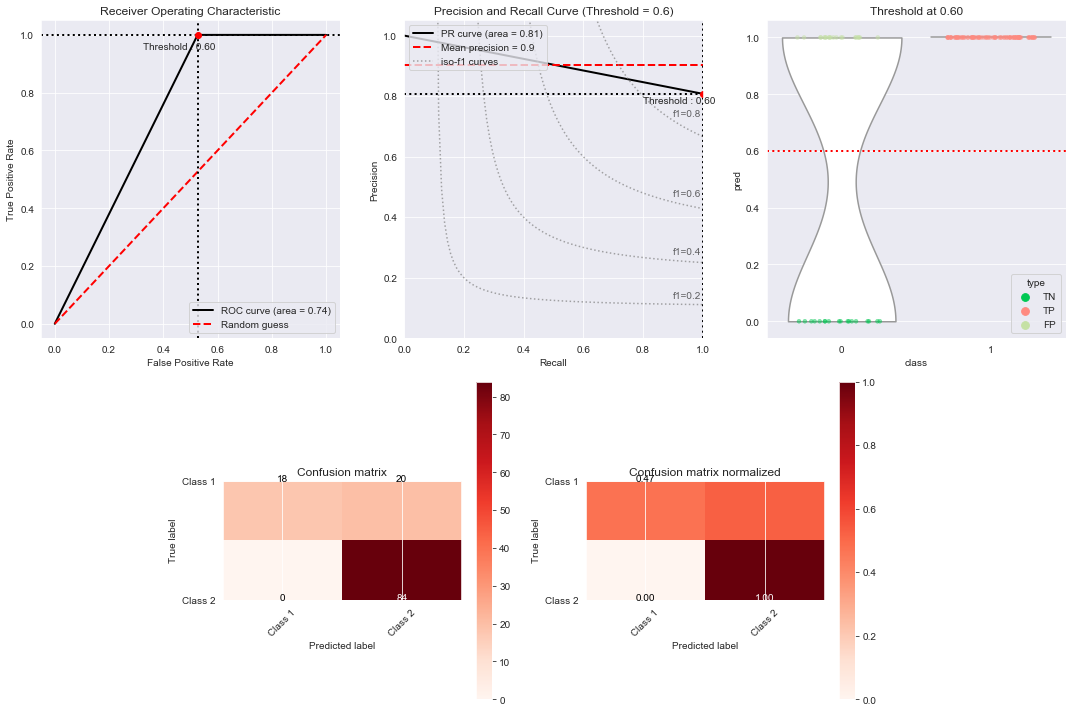

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       1.00      0.47      0.64        38
     Class 2       0.81      1.00      0.89        84

    accuracy                           0.84       122
   macro avg       0.90      0.74      0.77       122
weighted avg       0.87      0.84      0.82       122



In [50]:
bc = BinaryClassification(y_test, pred1, labels=["Class 1", "Class 2"],threshold=0.6)

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

<a> **AUC-Pre-recall-curve** = **0.81** </a>

<h1><center><a> 2.Support Vector Classifier </a></center></h1>

In [51]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
X_f = X
y_f = y
scaler = StandardScaler()
scaler.fit_transform(X_f)
i=1
kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X_f,y_f):
    print('\n{} of kfold {}'.format(i,kf.n_splits))    
    X_train,X_test = X_f.loc[train_index],X_f.loc[test_index]     
    y_train,y_test = y_f[train_index],y_f[test_index]         
    model = LinearSVC(max_iter = 100000)     
    model.fit(X_train, y_train)     
    pred2 = model.predict(X_test)    
    score = accuracy_score(y_test,pred2)
    precision = metrics.precision_score(y_test,pred2)
    recall = metrics.recall_score(y_test,pred2)
    F1_score = metrics.f1_score(y_test,pred2)
    print('accuracy_score',score)
    print('Precision',precision)
    print('Recall',recall)
    print('F1_score',F1_score)  
    i+=1

pred_test2 = model.predict(df_test) 


1 of kfold 10
accuracy_score 0.7936507936507936
Precision 0.7777777777777778
Recall 0.9767441860465116
F1_score 0.8659793814432991

2 of kfold 10
accuracy_score 0.8095238095238095
Precision 0.7818181818181819
Recall 1.0
F1_score 0.8775510204081634

3 of kfold 10
accuracy_score 0.7868852459016393
Precision 0.8085106382978723
Recall 0.9047619047619048
F1_score 0.853932584269663

4 of kfold 10
accuracy_score 0.8360655737704918
Precision 0.8076923076923077
Recall 1.0
F1_score 0.8936170212765957

5 of kfold 10
accuracy_score 0.7868852459016393
Precision 0.7636363636363637
Recall 1.0
F1_score 0.865979381443299

6 of kfold 10
accuracy_score 0.819672131147541
Precision 0.803921568627451
Recall 0.9761904761904762
F1_score 0.8817204301075269

7 of kfold 10
accuracy_score 0.819672131147541
Precision 0.803921568627451
Recall 0.9761904761904762
F1_score 0.8817204301075269

8 of kfold 10
accuracy_score 0.7704918032786885
Precision 0.75
Recall 1.0
F1_score 0.8571428571428571

9 of kfold 10
accuracy_

* Accuracy = **83.6%**
* Precision = **80.7%**
* Recall = **100%**
* F1_score = **89.3%**

<a> AUC-ROC curve </a>

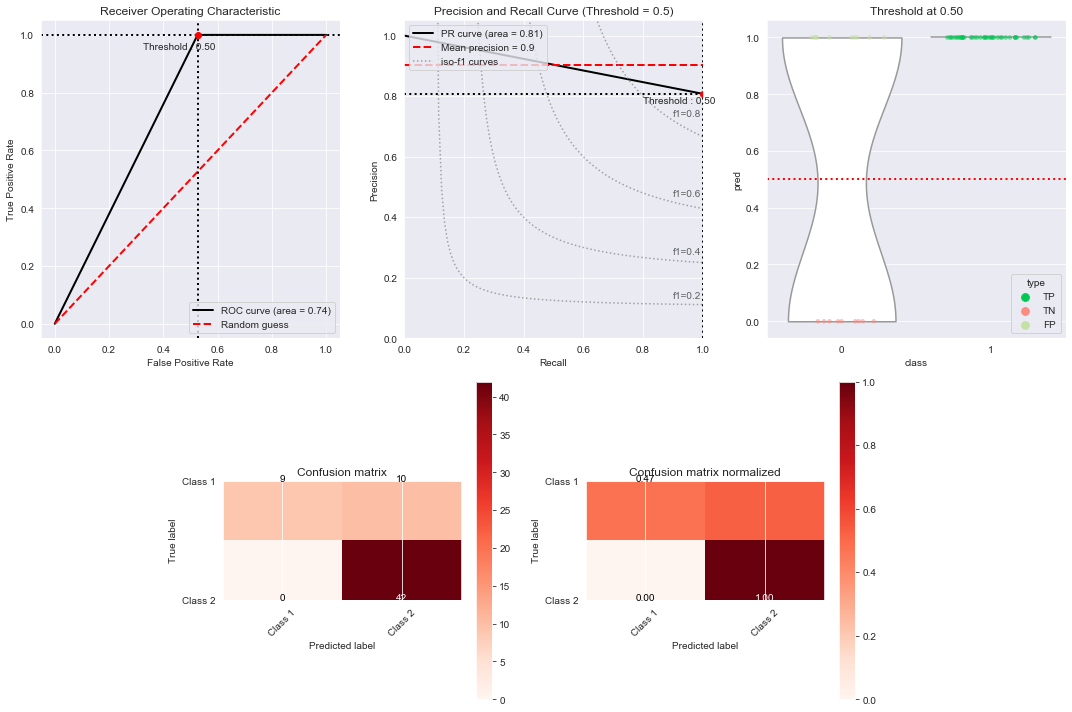

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       1.00      0.47      0.64        19
     Class 2       0.81      1.00      0.89        42

    accuracy                           0.84        61
   macro avg       0.90      0.74      0.77        61
weighted avg       0.87      0.84      0.82        61



In [52]:
bc = BinaryClassification(y_test, pred2, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

* AUC(ROC) = **74%**
* AUC(PR) = **81%**

<h1><center><a> 3. Random Forest Approach </a></center></h1>

In [53]:
from sklearn.ensemble import RandomForestClassifier
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train,X_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    model = RandomForestClassifier(random_state=1,max_depth=10)
    model.fit(X_train,y_train)
    pred3 = model.predict(X_test)
    score = metrics.accuracy_score(y_test,pred3)
    precision = metrics.precision_score(y_test,pred3)
    recall = metrics.recall_score(y_test,pred3)
    F1_score = metrics.f1_score(y_test,pred3)
    print('Accuracy:',score)
    print('Precision:',precision)
    print('recall',recall)
    print('F1_score',F1_score)
    i+=1

pred_test3 = model.predict(df_test)


1 of kfold 5
Accuracy: 0.8064516129032258
Precision: 0.8210526315789474
recall 0.9176470588235294
F1_score 0.8666666666666667

2 of kfold 5
Accuracy: 0.7903225806451613
Precision: 0.8172043010752689
recall 0.8941176470588236
F1_score 0.8539325842696629

3 of kfold 5
Accuracy: 0.7704918032786885
Precision: 0.78
recall 0.9285714285714286
F1_score 0.8478260869565217

4 of kfold 5
Accuracy: 0.7704918032786885
Precision: 0.7857142857142857
recall 0.9166666666666666
F1_score 0.8461538461538461

5 of kfold 5
Accuracy: 0.8114754098360656
Precision: 0.8144329896907216
recall 0.9404761904761905
F1_score 0.8729281767955801


* Accuracy = **81%**
* Precision = **81%**
* Recall = **94%**
* F1_score = **87%**

<a> **AUC-ROC Curve** </a>

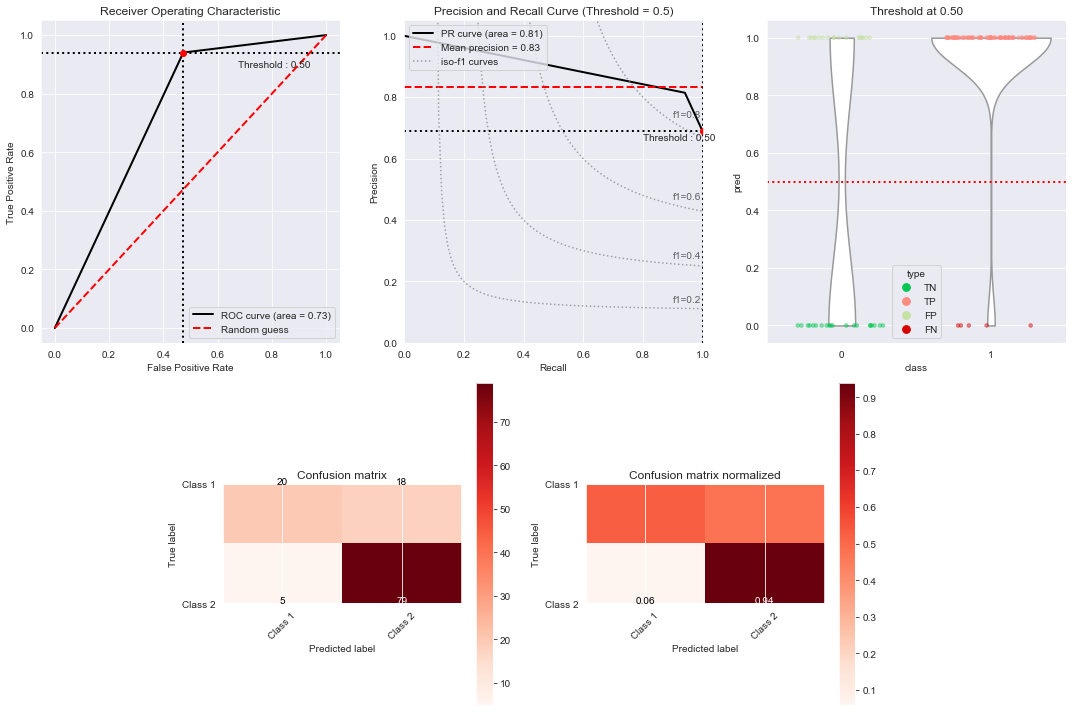

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.80      0.53      0.63        38
     Class 2       0.81      0.94      0.87        84

    accuracy                           0.81       122
   macro avg       0.81      0.73      0.75       122
weighted avg       0.81      0.81      0.80       122



In [54]:
bc = BinaryClassification(y_test, pred3, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

* AUC-ROC = **73%**
* AUC-PR = **81%**

<h2><a> Tuning The Hyperparameters of Random-Forest using Grid-Search </a></h2>

In [55]:
from sklearn.model_selection import GridSearchCV
# Provide range for max_depth from 1 to 20 with an interval of 2 and from 1 to 200 with an interval of 20 for n_estimators 
paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=1)
# Fit the grid search model 
grid_search.fit(X_train,y_train)
GridSearchCV(cv=None, error_score='raise', estimator=RandomForestClassifier(bootstrap=True, class_weight=None, 
            criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
            min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1, verbose=0, warm_start=False),       
            iid=True, n_jobs=1, param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 
                                                            'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]},       
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',       
            scoring=None, verbose=0)
# Estimating the optimized value 
grid_search.best_estimator_

C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=81,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

<h2><a> Random-Forest using tuned Hyperparameters </a></h2>

In [56]:
from sklearn.ensemble import RandomForestClassifier
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    X_train,X_test = X.loc[train_index],X.loc[test_index]     
    y_train,y_test = y[train_index],y[test_index]         
    model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)     
    model.fit(X_train, y_train)     
    pred4 = model.predict(X_test)     
    score = accuracy_score(y_test,pred4) 
    precision = metrics.precision_score(y_test,pred4)
    recall = metrics.recall_score(y_test,pred4)
    F1_score = metrics.f1_score(y_test,pred4)
    print('Accuracy:',score)
    print('Precision:',precision)
    print('recall',recall)
    print('F1_score',F1_score)
    i+=1

pred_test3 = model.predict(df_test)


1 of kfold 5
Accuracy: 0.8064516129032258
Precision: 0.7904761904761904
recall 0.9764705882352941
F1_score 0.8736842105263157

2 of kfold 5
Accuracy: 0.8064516129032258
Precision: 0.801980198019802
recall 0.9529411764705882
F1_score 0.8709677419354839

3 of kfold 5
Accuracy: 0.8032786885245902
Precision: 0.7830188679245284
recall 0.9880952380952381
F1_score 0.8736842105263158

4 of kfold 5
Accuracy: 0.7950819672131147
Precision: 0.7757009345794392
recall 0.9880952380952381
F1_score 0.8691099476439791

5 of kfold 5
Accuracy: 0.8360655737704918
Precision: 0.8076923076923077
recall 1.0
F1_score 0.8936170212765957


* Accuracy = **83.6%**
* Precision = **80.7%**
* Recall = **100%**
* F1_score = **89.3%**

<a> **ROC-AUC Curve** </a>

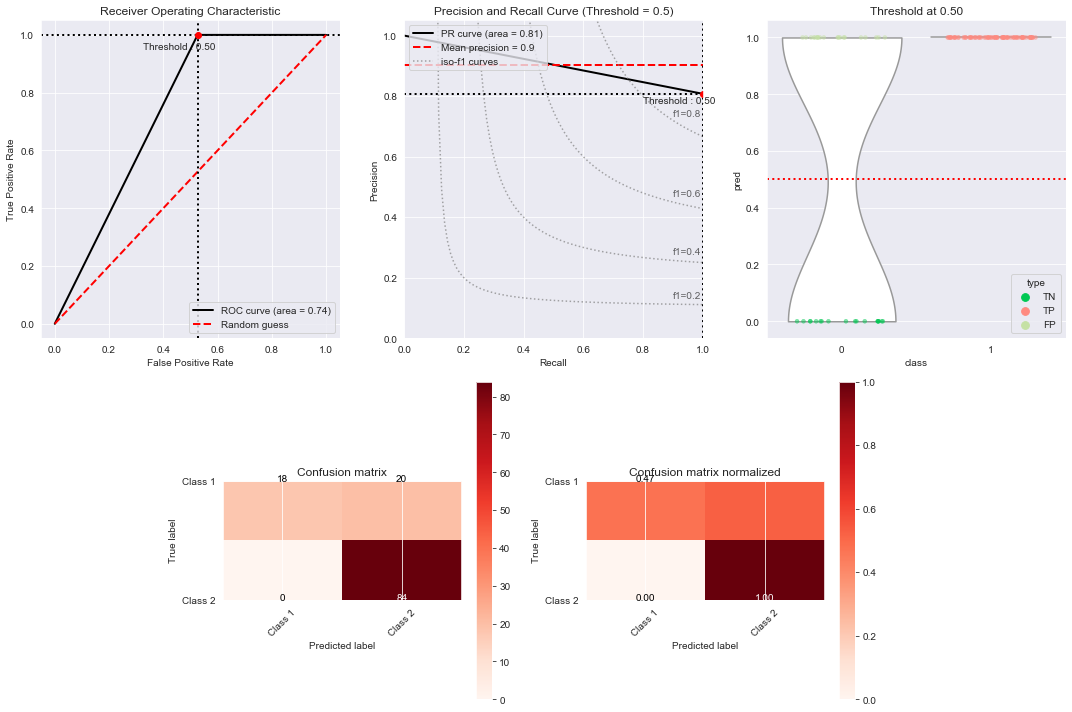

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       1.00      0.47      0.64        38
     Class 2       0.81      1.00      0.89        84

    accuracy                           0.84       122
   macro avg       0.90      0.74      0.77       122
weighted avg       0.87      0.84      0.82       122



In [57]:
bc = BinaryClassification(y_test, pred4, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

* AUC-ROC = **74%**
* AUC-PR = **81%**

<h2><a> Best Features </a></h2>

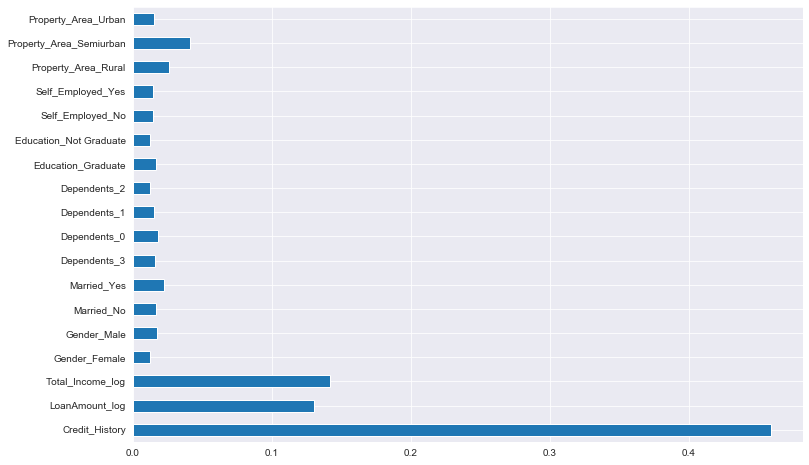

In [58]:
importances=pd.Series(model.feature_importances_, index=X.columns) 
importances.plot(kind='barh', figsize=(12,8))

<h1><center><a> 4. XGBoost Classifier </a></center></h1>

In [59]:
from xgboost import XGBClassifier

In [60]:
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train,X_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    model = XGBClassifier(n_estimators=50,max_depth=4)
    model.fit(X_train,y_train)
    pred5 = model.predict(X_test)
    score = accuracy_score(y_test,pred5) 
    precision = metrics.precision_score(y_test,pred5)
    recall = metrics.recall_score(y_test,pred5)
    F1_score = metrics.f1_score(y_test,pred5)
    print('Accuracy:',score)
    print('Precision:',precision)
    print('recall',recall)
    print('F1_score',F1_score)
    i+=1

pred_test4 = model.predict(df_test)


1 of kfold 5
Accuracy: 0.7983870967741935
Precision: 0.7941176470588235
recall 0.9529411764705882
F1_score 0.8663101604278074

2 of kfold 5
Accuracy: 0.8064516129032258
Precision: 0.801980198019802
recall 0.9529411764705882
F1_score 0.8709677419354839

3 of kfold 5
Accuracy: 0.7868852459016393
Precision: 0.7843137254901961
recall 0.9523809523809523
F1_score 0.8602150537634408

4 of kfold 5
Accuracy: 0.7868852459016393
Precision: 0.7735849056603774
recall 0.9761904761904762
F1_score 0.863157894736842

5 of kfold 5
Accuracy: 0.8278688524590164
Precision: 0.8181818181818182
recall 0.9642857142857143
F1_score 0.8852459016393442


* Accuracy = **83%**
* Precision = **82%**
* Recall = **96%**
* F1_score = **88.5%**

<h2><a> HyperParameter Tuning of XGBoost </a></h2>

In [61]:
paramgrid = {
 'max_depth':range(3,30,2),
 'min_child_weight':range(1,20,2)
}
grid_search=GridSearchCV(XGBClassifier(random_state=1),paramgrid)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=1)
grid_search.fit(X_train,y_train)
GridSearchCV(cv=None, error_score='raise', estimator=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1,
             silent=None, objective='binary:logistic', booster='gbtree',
             n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
             max_delta_step=0, subsample=1, colsample_bytree=1, 
             colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, 
            reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=1, 
            seed=None, missing=None), iid=False, n_jobs=1,param_grid=paramgrid,
              pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',       
            scoring=None, verbose=0)
grid_search.best_estimator_

C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<h2><a> XGBClassifier After Parameter tuning </a></h2>

In [62]:
i=1 
X_f = X
y_f = y
scaler = StandardScaler()
scaler.fit(X_f)
scaler.transform(X_f)
kf = StratifiedKFold(n_splits=7,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X_f,y_f):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    X_train,X_test = X.loc[train_index],X.loc[test_index]     
    y_train,y_test = y.loc[train_index],y.loc[test_index]         
    model2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1,verbosity=1)     
    model2.fit(X_train, y_train)     
    pred6 = model.predict(X_test)     
    score = accuracy_score(y_test,pred6)
    precision = metrics.precision_score(y_test,pred6)
    recall = metrics.recall_score(y_test,pred6)
    F1_score = metrics.f1_score(y_test,pred6)
    print('Accuracy:',score)
    print('Precision:',precision)
    print('recall',recall)
    print('F1_score',F1_score)
    i+=1

pred_test6 = model.predict(df_test)


1 of kfold 7
Accuracy: 0.8314606741573034
Precision: 0.8194444444444444
recall 0.9672131147540983
F1_score 0.8872180451127819

2 of kfold 7
Accuracy: 0.8539325842696629
Precision: 0.8333333333333334
recall 0.9836065573770492
F1_score 0.9022556390977444

3 of kfold 7
Accuracy: 0.8863636363636364
Precision: 0.8676470588235294
recall 0.9833333333333333
F1_score 0.9218749999999999

4 of kfold 7
Accuracy: 0.8390804597701149
Precision: 0.8194444444444444
recall 0.9833333333333333
F1_score 0.893939393939394

5 of kfold 7
Accuracy: 0.8620689655172413
Precision: 0.8428571428571429
recall 0.9833333333333333
F1_score 0.9076923076923077

6 of kfold 7
Accuracy: 0.8620689655172413
Precision: 0.8333333333333334
recall 1.0
F1_score 0.9090909090909091

7 of kfold 7
Accuracy: 0.8160919540229885
Precision: 0.8142857142857143
recall 0.95
F1_score 0.8769230769230769


* Accuracy = **85%**
* Precision = **82%**
* Recall = **100%**
* F1_score = **90%**

<a> **ROC-AUC Curve** </a>

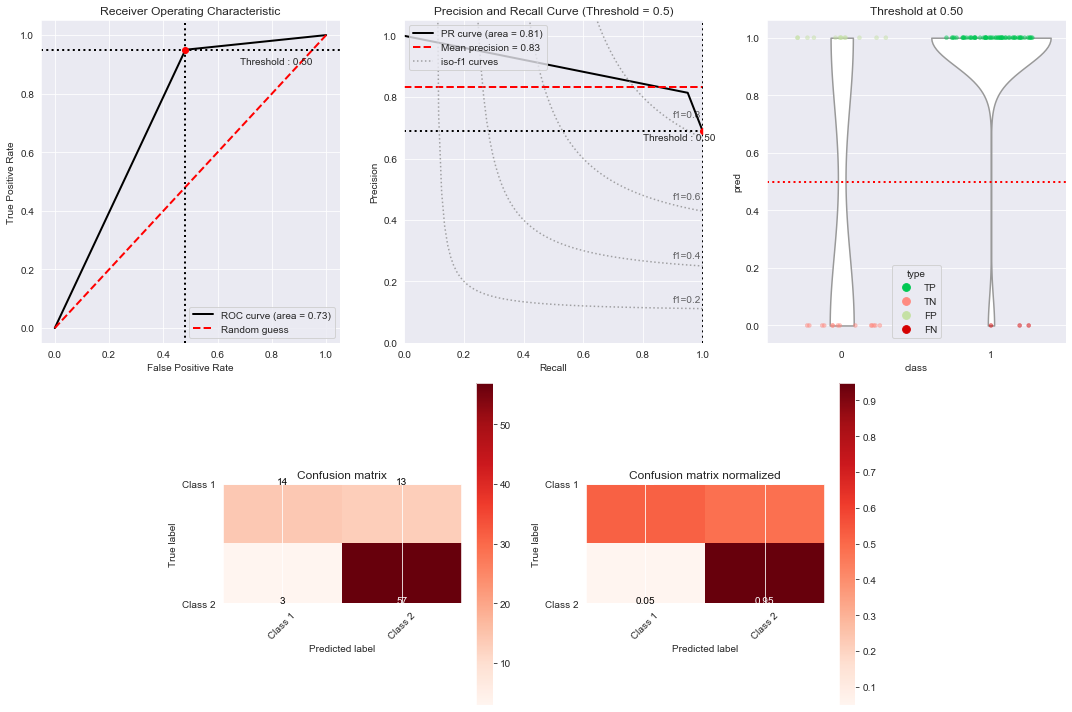

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.82      0.52      0.64        27
     Class 2       0.81      0.95      0.88        60

    accuracy                           0.82        87
   macro avg       0.82      0.73      0.76        87
weighted avg       0.82      0.82      0.80        87



In [63]:
bc = BinaryClassification(y_test, pred6, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

* AUC-ROC = **76%**
* AUC-PR = **82%**

<h1><center><a> 5. AdaBoost Classifier </a></center></h1>

In [64]:
from sklearn.ensemble import AdaBoostClassifier
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X_f,y_f):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    X_train,X_test = X.loc[train_index],X.loc[test_index]     
    y_train,y_test = y.loc[train_index],y.loc[test_index]         
    model =  AdaBoostClassifier(n_estimators=100)   
    model.fit(X_train,y_train)     
    pred7 = model.predict(X_test)     
    score = accuracy_score(y_test,pred7)
    precision = metrics.precision_score(y_test,pred7)
    recall = metrics.recall_score(y_test,pred7)
    F1_score = metrics.f1_score(y_test,pred7)
    print('Accuracy:',score)
    print('Precision:',precision)
    print('recall',recall)
    print('F1_score',F1_score)
    i+=1

pred_test7 = model.predict(df_test)


1 of kfold 5
Accuracy: 0.7903225806451613
Precision: 0.7920792079207921
recall 0.9411764705882353
F1_score 0.8602150537634408

2 of kfold 5
Accuracy: 0.7983870967741935
Precision: 0.8
recall 0.9411764705882353
F1_score 0.8648648648648648

3 of kfold 5
Accuracy: 0.8032786885245902
Precision: 0.7941176470588235
recall 0.9642857142857143
F1_score 0.8709677419354839

4 of kfold 5
Accuracy: 0.7459016393442623
Precision: 0.7731958762886598
recall 0.8928571428571429
F1_score 0.8287292817679559

5 of kfold 5
Accuracy: 0.8032786885245902
Precision: 0.8333333333333334
recall 0.8928571428571429
F1_score 0.8620689655172413


* Accuracy = **80.3%**
* Precision = **83.33%**
* Recall = **89%**
* F1_score = **86%**

<a> **ROC-AUC Curve** </a>

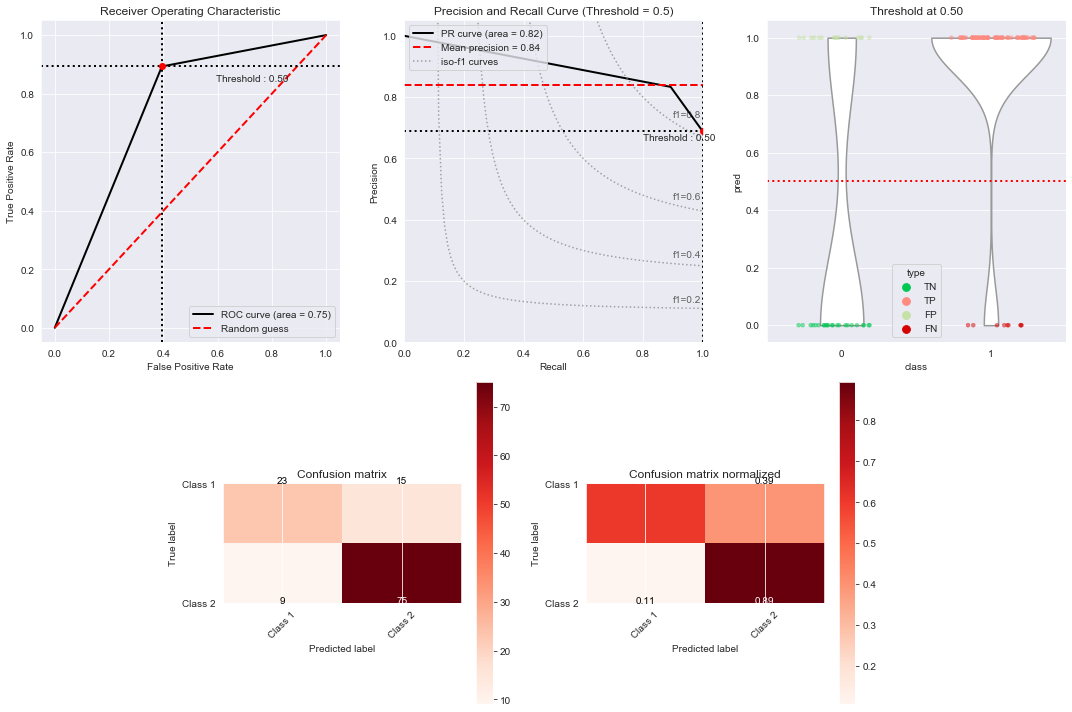

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.72      0.61      0.66        38
     Class 2       0.83      0.89      0.86        84

    accuracy                           0.80       122
   macro avg       0.78      0.75      0.76       122
weighted avg       0.80      0.80      0.80       122



In [65]:
bc = BinaryClassification(y_test, pred7, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

* AUC-ROC = **75%**
* AUC-PR = **82%**

<h1><center><a> Results Of All Models </a></center></h1>

1. Logistic Regression
    * Accuracy = **83.6%**
    * AUC-PR =  **81%**
    * F1_score = **89.3%**
2. Support Vector Classifier
    * Accuracy = **83.6%**
    * AUC-PR = **81%**
    * F1_score = **89.3%**
3. Random-Forest
    * Accuracy = **81%**
    * AUC-PR = **81%**
    * F1_score = **89.3%**
4. XGBoost
    * Accuracy = **85%**
    * AUC-PR = **82%**
    * F1_score = **90%**
5. AdaBoost
    * Accuracy = **80.3%**
    * AUC-PR = **82%**
    * F1_score = **86%**


<a>  So we can see that **Logistic-Regression** and **XGBoost** are performing very well , so we can take them into consideration. </a>

In [66]:
# Splitting Training data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3,random_state=1)

<h1><center><a> Stacking </a></center></h1>

In [67]:
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((0,1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,test_indices in folds.split(train,y.values):
        X_train,X_test=train.iloc[train_indices],train.iloc[test_indices]
        y_train,y_test=y.iloc[train_indices],y.iloc[test_indices]
        model.fit(X=X_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(X_test))
    test_pred=np.append(test_pred,model.predict(test))
    return test_pred.reshape(-1,1),train_pred

In [68]:
test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10,train=X_train,test=X_test,y=y_train)

train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

In [69]:
test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=X_train,test=X_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [74]:
df_train_stack = pd.concat([train_pred1, train_pred2], axis=1)
df_test_stack = pd.concat([test_pred1, test_pred2], axis=1)
model_stack = LogisticRegression(random_state=1,solver='lbfgs',max_iter=15000)
model_stack.fit(df_train_stack,y_train)
model_stack.score(df_test_stack, y_test)

0.7891891891891892